In [2]:
import numpy as np
import nengo
from nengo import Lowpass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from model import DotPerception, build_network, detect_extrema_dot_motion
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [2]:
def make_churchland_behavior_dataframe():
    # convert original matlab files into a single pandas dataframe
    # WARNING! This will produce a 2GB pickle file
    coherences = [0.032, 0.064, 0.128, 0.256, 0.512, 0.768]
    dfs = []
    columns = ('type', 'trial', 'nActions', 'coherence', 'RT', 'accuracy')
    emp = scipy.io.loadmat("data/both_monkeys_lip_nocon.mat", simplify_cells=True)['both_monkeys_lip_nocon']
    filter = Lowpass(tau=0.03)  # 30ms filter applied to spike times

    for neuron in range(len(emp)):
        for nActions in [2, 4]:
            if len(emp[neuron]['allnums'][nActions-1]['data'])==0: continue  # empty data
            for c, coherence in enumerate(coherences):
                # select preferred direction (0) and coherence (c)
                # note that we select stimulus-aligned data ('dotfire_time'), but both alignments are actually available within this data
                if c >= len(emp[neuron]['allnums'][nActions-1]['data'][0]['dotfire_time']): continue  # empty data
                dat = emp[neuron]['allnums'][nActions-1]['data'][0]['dotfire_time'][c]['spiketimes']
                for trial in range(len(dat)):
                    print(f"neuron {neuron}, nActions {nActions}, coherence {coherence}, trial {trial}")
                    if type(dat[trial]['rt']) != float: continue  # empty data, skip
                    RT = int(dat[trial]['rt'])
                    accuracy = 100 if dat[trial]['score']==1 else 0
                    if coherence==0: accuracy=1/nActions  # accuracy is meaningless when coherence=0, since there is no right answer
                    dfs.append(pd.DataFrame([['monkey', trial, nActions, 100*coherence, RT/1000, accuracy]], columns=columns))

    churchland = pd.concat(dfs, ignore_index=True)
    churchland.to_pickle("data/churchland2008_behavior.pkl")

In [3]:
# make_churchland_behavior_dataframe()

In [4]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

def get_error(simulated, empirical, coherences, bins=np.arange(0.0, 2.0, 0.2)):
    total_loss = 0
    for nActions in [2,4]:
        chis = []
        accs = []
        for coherence in coherences:
            rts_sim = simulated.query("nActions==@nActions & coherence==@coherence")['RT'].to_numpy()
            rts_emp = empirical.query("nActions==@nActions & coherence==@coherence")['RT'].to_numpy()
            accs_sim = simulated.query("nActions==@nActions & coherence==@coherence")['accuracy'].to_numpy()
            accs_emp = empirical.query("nActions==@nActions & coherence==@coherence")['accuracy'].to_numpy()
            hist_rts_sim = np.histogram(rts_sim, bins=bins)[0]
            hist_rts_emp = np.histogram(rts_emp, bins=bins)[0]
            normed_hist_rts_sim = hist_rts_sim / len(rts_sim)
            normed_hist_rts_emp = hist_rts_emp / len(rts_emp)
            chi = chi_squared_distance(normed_hist_rts_sim, normed_hist_rts_emp)
            acc = np.abs(np.mean(accs_sim) - np.mean(accs_emp))
            chis.append(chi)
            accs.append(acc)
        # print('nActions', nActions, f'chi2 {np.mean(chis):.3}', f'accuracy {np.mean(accs):.3}')
        print('nActions', nActions, f'chi2 {np.sum(chis):.3}', f'accuracy {np.sum(accs):.3}')

In [5]:
def single_trial(
        coherence,
        ramp=1,
        threshold=0.5,
        sigma=0.3,
        nNeurons=1000,
        max_rates=nengo.dists.Uniform(60, 80),
        rA=1.0,
        trials=3,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        dt_sample=0.01,
        relative=0,
        load=False,
        error=('ci', 95),  # ("pi", 50),
        tmax=2,
        name="multiple_alternatives"):


    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7, 2.5)))
    for n, nActions in enumerate([2, 4]):
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        inputs.create(coherence=coherence)
        net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=network_seed+perception_seed, max_rates=max_rates,
                            ramp=ramp, threshold=threshold, relative=relative)
        sim = nengo.Simulator(net, progress_bar=False)
        choice = None
        RT = None
        while choice==None:
            sim.run(dt)
            if np.any(sim.data[net.pAction][-1,:] > 0.01):
                choice = np.argmax(sim.data[net.pAction][-1,:])
                RT = sim.trange()[-1]
            if sim.trange()[-1] > tmax:
                choice = np.argmax(sim.data[net.pValue][-1,:])
                RT = sim.trange()[-1]
            correct = 1 if choice==net.inputs.correct else 0

        for a in range(nActions):
            axes[n].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a], label=f"Value {a}") 
        for a in range(nActions):
            ideal = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
            axes[n].plot(sim.trange(), ideal, color=palette[a], label=f"True {a}", linestyle="--") 
        axes[n].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), color="red", linestyle=":")
        axes[n].set(xlabel="Time (s)", title=f"{nActions} Actions")
        axes[n].legend(loc='upper left', ncol=2)
    axes[0].set(ylabel=r"$\mathbf{V}(t)$")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

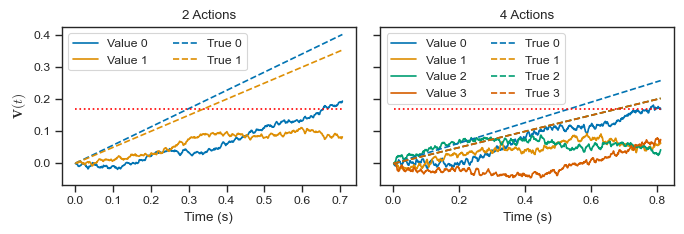

In [6]:
single_trial(coherence=0.064, ramp=1.07, relative=0.61, threshold=0.17, trials=100,
                nNeurons=500, max_rates=nengo.dists.Uniform(80, 100), rA=1.5, sigma=0.5, dt_sample=0.03,
                perception_seed=2, name="dynamics6")

In [7]:
def simulate(
        coherences=[0.032, 0.064, 0.128, 0.256, 0.512],
        ramps=[1,1],
        thresholds=[0.5,0.5],
        relatives=[0,0],
        sigmas=[0.3, 0.3],
        dt_samples=[0.01,0.01],
        nActs=[2, 4],
        nNeurons=500,
        max_rates=nengo.dists.Uniform(60, 80),
        rA=1.0,
        trials=3,
        perception_seed=0,
        dt=0.001,
        tmax=2,
        bins=np.arange(0.0, 2, 0.2),
        name="churchland_sim"):
    
    cohs = 100*np.array(coherences)
    columns = ('type', 'trial', 'coherence', 'nActions', 'RT', 'accuracy')  # same as Churchland dataframe
    dfs = []
    for n, nActions in enumerate(nActs):
        ramp = ramps[n]
        threshold = thresholds[n]
        relative = relatives[n]
        sigma = sigmas[n]
        dt_sample = dt_samples[n]
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        for coherence in coherences:
            print(f"nActions {nActions}, coherence {coherence}")
            for trial in range(trials):
                inputs.create(coherence=coherence)
                net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                    max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > tmax:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = True if choice==inputs.correct else False
                # print(f"nActions {nActions}, coherence {coherence}, trial {trial}, RT {RT}")
                dfs.append(pd.DataFrame([['model', trial, 100*coherence, nActions, RT, 100*correct]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

In [8]:
def simulate_extrema(
        coherences=[0.032, 0.064, 0.128, 0.256, 0.512],
        sigmas=[0.3, 0,3],
        thresholds=[1.0, 1.0],
        tiebreakers=['largest', 'largest'],
        dt_samples=[0.01, 0.01],
        nd_means=[0,0],
        nd_sigmas=[0,0],
        tmax=2,
        trials=200,
        perception_seed=0,
        network_seed=0,
        nActs = [2, 4],
        name='churchland_extrema_separate'):
    
    cohs = 100*np.array(coherences)
    rng = np.random.RandomState(seed=network_seed)
    columns = ('type', 'trial', 'coherence', 'nActions', 'RT', 'accuracy')  # same as Churchland dataframe
    dfs = []
    for n, nActions in enumerate(nActs):
        threshold = thresholds[n]
        dt_sample = dt_samples[n]
        tiebreaker = tiebreakers[n]
        sigma = sigmas[n]
        nd_mean = nd_means[n]
        nd_sigma = nd_sigmas[n]
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        for coherence in coherences:
            for trial in range(trials):
                inputs.create(coherence=coherence)
                choice, RT = detect_extrema_dot_motion(inputs, threshold, tiebreaker, tmax=tmax, seed=network_seed)
                correct = True if choice==inputs.correct else False
                ndt = rng.normal(nd_mean, nd_sigma)
                ndt = np.max([0, ndt])
                RT += ndt  # add non-decision time to model's RT
                RT = np.min([tmax, RT])
                # print(f"nActions {nActions}, coherence {coherence}, trial {trial}, RT {RT}")
                dfs.append(pd.DataFrame([['extrema', trial, 100*coherence, nActions, RT, 100*correct]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

# Plotting

In [3]:
def plot_correct_incorrect(simfile, extrfile, empfile="churchland2008_behavior", error=('ci', 95), estimator=np.median, bins=np.arange(0.0, 2, 0.2)):
    
    sim = pd.read_pickle(f'data/{simfile}.pkl')
    extr = pd.read_pickle(f'data/{extrfile}.pkl')
    emp = pd.read_pickle(f'data/{empfile}.pkl')
    combined = pd.concat([emp, sim, extr])
    cohs = combined['coherence'].unique()[:-2]
    combined = combined.query("coherence in @cohs")

    fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=((7.08, 6)))
    sns.lineplot(data=combined.query("nActions==2 & type=='monkey'"), x='coherence', y='RT', style='accuracy', color=palette[0], markers=True, ax=axes[0][0],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("nActions==4 & type=='monkey'"), x='coherence', y='RT', style='accuracy', color=palette[0], markers=True, ax=axes[0][1],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("nActions==2 & type=='model'"), x='coherence', y='RT', style='accuracy', color=palette[1], markers=True, ax=axes[1][0],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("nActions==4 & type=='model'"), x='coherence', y='RT', style='accuracy', color=palette[1], markers=True, ax=axes[1][1],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("nActions==2 & type=='extrema'"), x='coherence', y='RT', style='accuracy', color=palette[2], markers=True, ax=axes[2][0],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("nActions==4 & type=='extrema'"), x='coherence', y='RT',style='accuracy', color=palette[2], markers=True, ax=axes[2][1],
                 errorbar=error, estimator=estimator)
    axes[0][0].set(ylabel="Response Time (s)", title="2 Actions, Human")
    axes[0][1].set(title="4 Actions, Human")
    axes[1][0].set(title="2 Actions, Model")
    axes[1][1].set(title="4 Actions, Model")
    axes[2][0].set(title="2 Actions, Extrema")
    axes[2][1].set(title="4 Actions, Extrema")
    axes[2][0].set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Response Time (s)")
    axes[2][1].set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Response Time (s)")
    axes[0][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    axes[2][0].get_legend().remove()
    axes[2][1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/churchland_correct_incorrect.svg")
    fig.savefig(f"plots/churchland_correct_incorrect.png", dpi=600)

In [4]:
def plot_sat(simfile, extrfile, empfile="churchland2008_behavior", error=('ci', 95), estimator=np.median, bins=np.arange(0.0, 2, 0.2)):

    sim = pd.read_pickle(f'data/{simfile}.pkl')
    extr = pd.read_pickle(f'data/{extrfile}.pkl')
    emp = pd.read_pickle(f'data/{empfile}.pkl')
    combined = pd.concat([emp, sim, extr])
    combined = combined.query("coherence<70")
    cohs = combined['coherence'].unique()
    # get_error(combined.query("type=='model'"), combined.query("type=='monkey'"), cohs, bins=bins)

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 6)))
    sns.lineplot(data=combined, x='coherence', y='RT', hue='type', style='nActions', palette=palette[:3], markers=True, ax=axes[0],
                 errorbar=error, estimator=estimator, hue_order=['monkey', 'model', 'extrema'])
    sns.lineplot(data=combined, x='coherence', y='accuracy', hue='type', style='nActions', palette=palette[:3], markers=True, ax=axes[1],
                 hue_order=['monkey', 'model', 'extrema'])
    axes[0].set(ylabel="Response Time (s)")
    axes[0].legend(ncols=2)
    # axes[1].set(xscale='log', xticks=[2, 3.2, 6.4, 12.8, 25.6, 51.4, 76.8], xlabel='Coherence', ylabel='Accuracy (%)')
    axes[1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)")
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/churchland_sat.svg")
    fig.savefig(f"plots/churchland_sat.png", dpi=600)

In [5]:
def plot_RTs(simfile, extrfile, empfile="churchland2008_behavior", error=('ci', 95), bins=np.arange(0.0, 2, 0.2)):

    sim = pd.read_pickle(f'data/{simfile}.pkl')
    extr = pd.read_pickle(f'data/{extrfile}.pkl')
    emp = pd.read_pickle(f'data/{empfile}.pkl').query("coherence<70")
    combined = pd.concat([emp, sim, extr])
    combined = combined.query("coherence<70")
    cohs = combined['coherence'].unique()

    fig = sns.FacetGrid(combined, col='nActions', row="coherence", hue='type', palette=palette[:3], height=1.5, aspect=2,
                        sharex=True, legend_out=True, hue_order=['monkey', 'model', 'extrema'])
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins, alpha=.3)
    fig.set_xlabels("Response Time (s)")
    fig.set(xticks=bins[::2])
    fig.set(yticks=[0,25,50,75,100])
    fig.add_legend()
    fig.savefig(f"plots/churchland_RTs.svg")
    fig.savefig(f"plots/churchland_RTs.png", dpi=600)

In [13]:
def plot_sat2(simfile, extrfile, ddfile, empfile="churchland2008_behavior", error=('ci', 95), estimator=np.median, bins=np.arange(0.0, 1.5, 0.1)):
    sim = pd.read_pickle(f'data/{simfile}.pkl')
    extr = pd.read_pickle(f'data/{extrfile}.pkl')
    dd = pd.read_pickle(f'data/{ddfile}.pkl')
    emp = pd.read_pickle(f'data/{empfile}.pkl').query("coherence<70")
    combined = pd.concat([emp, sim, dd, extr])
    cohs = combined['coherence'].unique()
    combined = combined.query("coherence in @cohs")

    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=((7, 5)))
    sns.lineplot(data=combined.query("nActions==2"), x='coherence', y='RT', hue='type',
                 palette=palette[:4], markers=True, ax=axes[0][0], estimator=estimator)
    sns.lineplot(data=combined.query("nActions==4"), x='coherence', y='RT', hue='type',
                 palette=palette[:4], markers=True, ax=axes[0][1], estimator=estimator)
    sns.lineplot(data=combined.query("nActions==2"), x='coherence', y='accuracy', hue='type',
                 palette=palette[:4], markers=True, ax=axes[1][0])
    sns.lineplot(data=combined.query("nActions==4"), x='coherence', y='accuracy', hue='type',
                 palette=palette[:4], markers=True, ax=axes[1][1])
    axes[0][0].set(xscale='log', ylabel="Response Time (s)", title="2 Actions")
    axes[0][1].set(ylabel="Response Time (s)", title="4 Actions")
    axes[1][0].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)", yticks=[50,60,70,80,90,100])
    axes[1][1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)")
    axes[0][0].legend(loc='lower left')
    axes[0][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/churchland_sat2.svg")
    fig.savefig(f"plots/churchland_sat2.png", dpi=600)

In [7]:
def plot_slow_errors(simfile, extrfile, ddfile, empfile="churchland2008_behavior",
                     bins=np.arange(0.0, 1.2, 0.1), bins2=np.arange(0.0, 1.7, 0.1), bw=1, cut=1):

    palette2 = sns.color_palette("tab10")[2:4]
    sim = pd.read_pickle(f'data/{simfile}.pkl')
    dd = pd.read_pickle(f'data/{ddfile}.pkl')
    extr = pd.read_pickle(f'data/{extrfile}.pkl')
    emp = pd.read_pickle(f'data/{empfile}.pkl')
    combined = pd.concat([emp, sim, dd, extr])
    cohs = combined['coherence'].unique()[:-2]
    combined = combined.query("coherence in @cohs")
    combined = combined.rename(columns={"coherence": "C"})

    fig = sns.FacetGrid(combined.query("nActions==2"), col='C', row="type", hue='accuracy', palette=palette[:2], height=1.5, aspect=1.5,
                        sharex=True, legend_out=False, hue_order=[100, 0], row_order=['monkey', 'model', 'DD', 'extrema'], despine=False)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', common_norm=False, bins=bins, alpha=0.3,  # element="poly",
                      kde=True, kde_kws={'bw_adjust': bw, 'cut': cut, 'clip': [bins[0], bins[-1]]})
    fig.set_xlabels("Response Time (s)")
    fig.set(xticks=bins[::2])
    fig.set(yticks=[0,10,20,30,40])
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/churchland_slow_errors_nActions2.svg")
    fig.savefig(f"plots/churchland_slow_errors_nActions2.png", dpi=600)

    fig = sns.FacetGrid(combined.query("nActions==4"), col='C', row="type", hue='accuracy', palette=palette[:2], height=1.5, aspect=1.5,
                        sharex=True, legend_out=False, hue_order=[100, 0], row_order=['monkey', 'model', 'DD', 'extrema'], despine=False)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', common_norm=False, bins=bins2,
                      kde=True, kde_kws={'bw_adjust': bw, 'cut': cut, 'clip': [bins2[0], bins2[-1]]}, alpha=0.3)
    fig.set_xlabels("Response Time (s)")
    fig.set(xticks=bins2[::2])
    fig.set(yticks=[0,10,20])
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/churchland_slow_errors_nActions4.svg")
    fig.savefig(f"plots/churchland_slow_errors_nActions4.png", dpi=600)

## Simulate (behavior)

In [15]:
simulate(
    trials=200,
    ramps=[1.52,1.96],
    thresholds=[0.19,0.26],
    relatives=[0.7,0.81],
    sigmas=[0.4, 0.32],
    dt_samples=[0.045,0.08],
    nActs=[2, 4],
    name="may17")
# 2 {'dt_sample': 0.045, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.52, 'relative': 0.7, 'sigma': 0.4, 'threshold': 0.19}
# 4 {'dt_sample': 0.08, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.96, 'relative': 0.81, 'sigma': 0.32, 'threshold': 0.26}

nActions 2, coherence 0.032


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:624: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


nActions 2, coherence 0.064
nActions 2, coherence 0.128
nActions 2, coherence 0.256
nActions 2, coherence 0.512
nActions 4, coherence 0.032
nActions 4, coherence 0.064
nActions 4, coherence 0.128
nActions 4, coherence 0.256
nActions 4, coherence 0.512


In [29]:
simulate(
    trials=1000,
    ramps=[1.52,1.96],
    thresholds=[0.19,0.26],
    relatives=[0.7,0.81],
    sigmas=[0.4, 0.32],
    dt_samples=[0.045,0.08],
    nActs=[2, 4],
    name="may17_1000trials")
# 2 {'dt_sample': 0.045, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.52, 'relative': 0.7, 'sigma': 0.4, 'threshold': 0.19}
# 4 {'dt_sample': 0.08, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.96, 'relative': 0.81, 'sigma': 0.32, 'threshold': 0.26}

nActions 2, coherence 0.032
nActions 2, coherence 0.064
nActions 2, coherence 0.128
nActions 2, coherence 0.256
nActions 2, coherence 0.512
nActions 4, coherence 0.032
nActions 4, coherence 0.064
nActions 4, coherence 0.128
nActions 4, coherence 0.256
nActions 4, coherence 0.512


In [35]:
simulate_extrema(
    trials=1000,
    thresholds=[0.85, 0.68],
    dt_samples=[0.006, 0.02],
    sigmas=[0.15, 0.19],
    nd_means=[0.33, 0.36],
    nd_sigmas=[0.02, 0.04],
    tiebreakers=['largest', 'largest'],
    name="churchland_extrema")

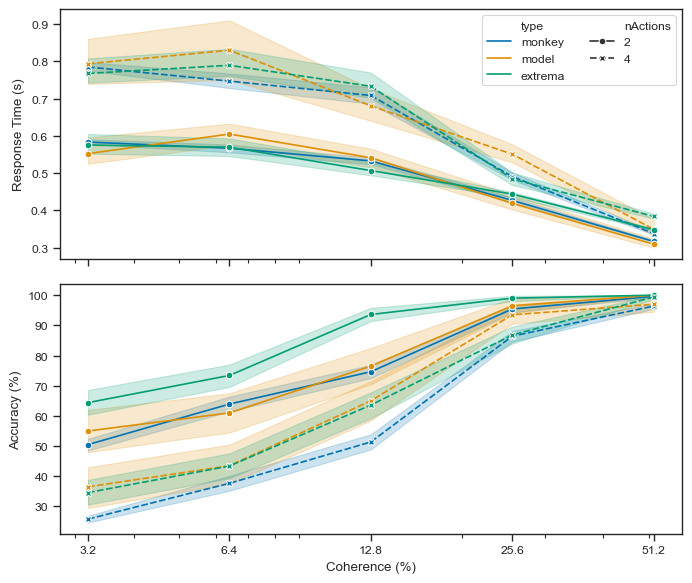

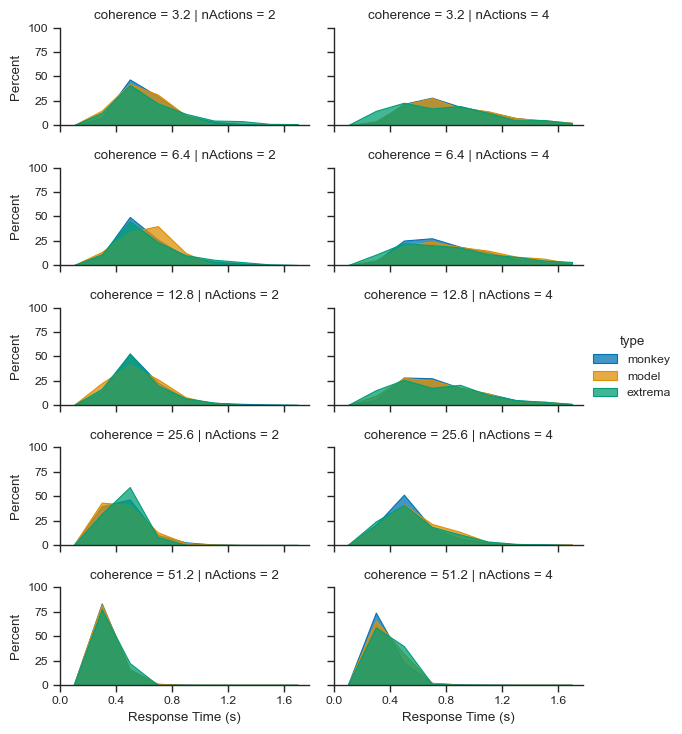

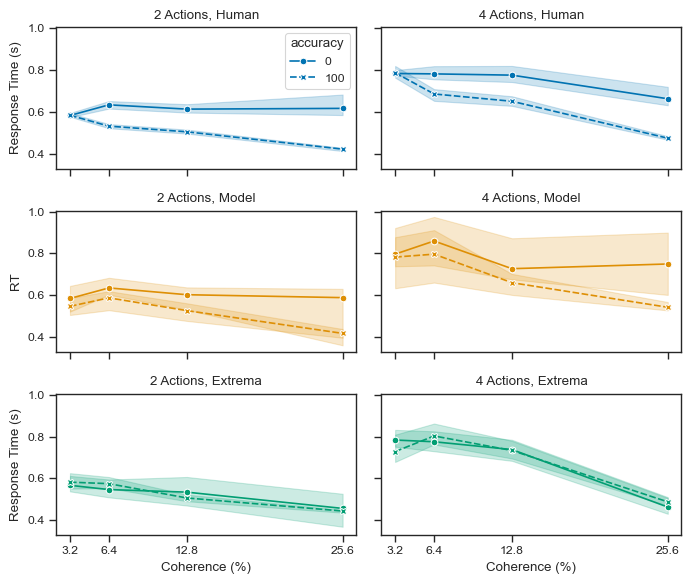

In [16]:
plot_sat("may17", "churchland_extrema_separate", "churchland2008_behavior")  # "dec14full"
plot_RTs("may17", "churchland_extrema_separate", "churchland2008_behavior")
plot_correct_incorrect("may17", "churchland_extrema_separate", "churchland2008_behavior")

[ 3.2  6.4 12.8 25.6 51.2]


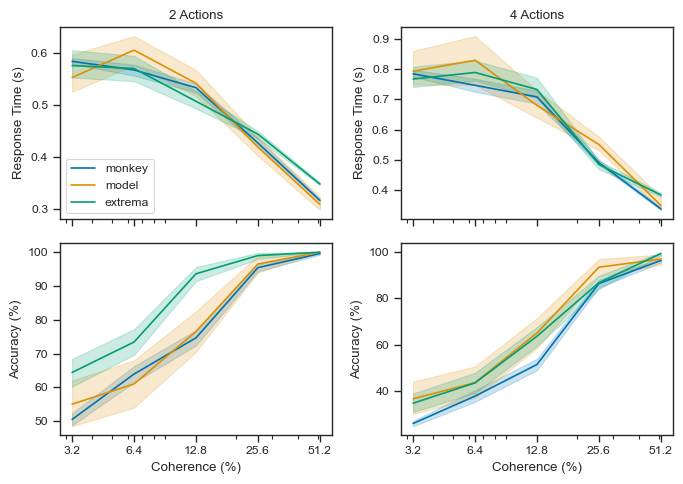

In [13]:
plot_sat2("may17", "churchland_extrema_separate", "churchland2008_behavior")

[ 3.2  6.4 12.8 25.6 51.2]


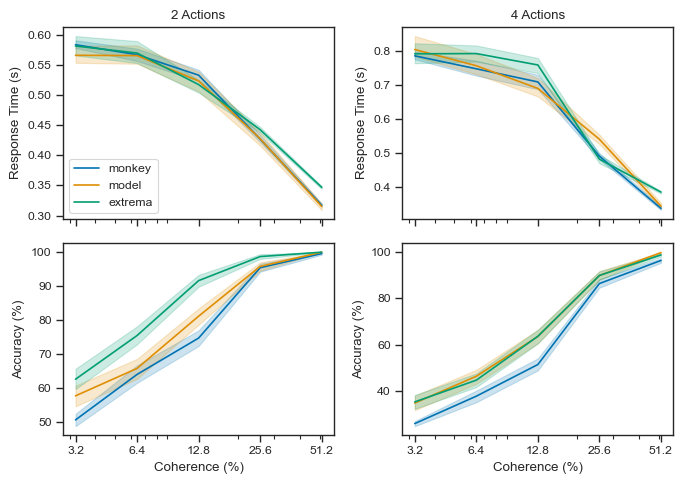

In [36]:
plot_sat2("may17_1000trials", "churchland_extrema", "churchland2008_behavior")

C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_988\503531140.py:13: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(data=combined.query("nActions==4"), x='coherence', y='RT', hue='type',
C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_988\503531140.py:17: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(data=combined.query("nActions==4"), x='coherence', y='accuracy', hue='type',


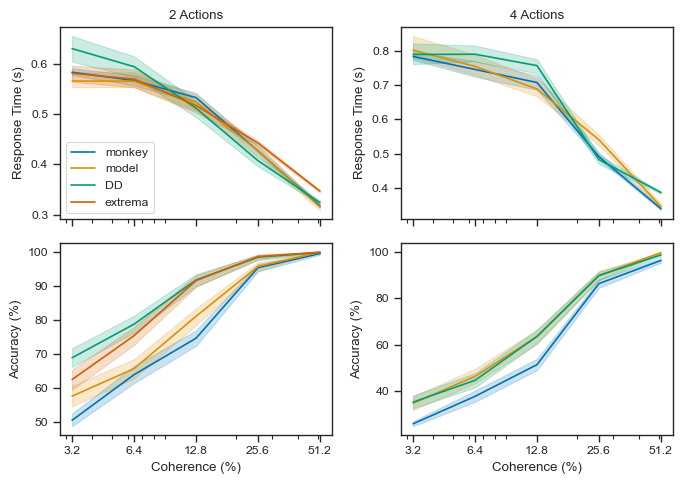

In [14]:
plot_sat2("may17_1000trials", "churchland_extrema", "churchland_DD", "churchland2008_behavior")

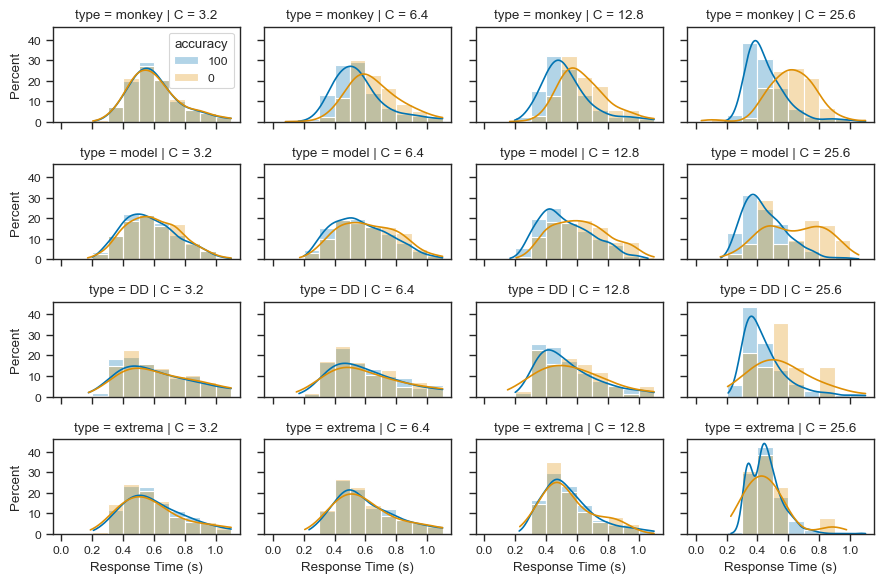

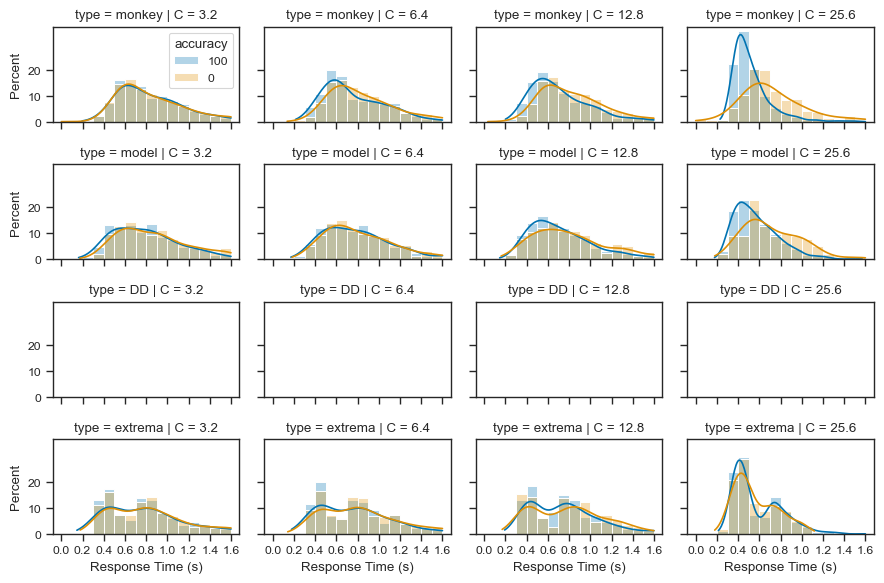

In [8]:
plot_slow_errors("may17_1000trials", "churchland_extrema", "churchland_DD", "churchland2008_behavior", bins=np.arange(0.0, 1.2, 0.1))

# Firing Rate Experiments

In [64]:
def rate_experiment(
        coherences=[0.032, 0.064, 0.128, 0.256, 0.512],
        nActs=[2,4],
        ramp=1,
        threshold=0.5,
        relative=0,
        sigma=0.3,
        nNeurons=500,
        max_rates=nengo.dists.Uniform(60, 80),
        rA=1.0,
        trials=3,
        perception_seed=0,
        dt=0.001,
        dt_sample=0.01,
        tmax=2,
        t0=0.15,
        t1=0.3,
        t2=-0.3,
        name="churchland_sim_firing"):
    
    dfs = []
    for nActions in nActs:
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        for coherence in coherences:
            inputs.create(coherence=coherence)
            print(f"nActions {nActions}, coherence {coherence}")
            for trial in range(trials):
                net = build_network(inputs, nActions=nActions, seed=trial,
                                    ramp=ramp, threshold=threshold, relative=relative,
                                    nNeurons=nNeurons, rA=rA, max_rates=max_rates, probe_spikes=True)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                RT = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > tmax:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = 1 if choice==net.inputs.correct else 0
                # print(f"trial {trial}, coherence {coherence}, nActions {nActions}, correct {correct}, RT {RT}")
                aligned_neuron_idx = np.argwhere(sim.data[net.value].encoders[:,net.inputs.correct] > 0.9)
                for neuron in aligned_neuron_idx:
                    df = pd.DataFrame()
                    df['type'] = ['model' for _ in range(len(sim.trange()))]
                    df['time'] = sim.trange()
                    df['time2'] = -1*sim.trange()[::-1]
                    df['nActions'] =  nActions*np.ones_like(sim.trange())
                    df['coherence'] =  100*coherence*np.ones_like(sim.trange())
                    df['trial'] =  trial*np.ones_like(sim.trange())
                    df['accuracy'] = 100*correct*np.ones_like(sim.trange())
                    df['RT'] = RT*np.ones_like(sim.trange())
                    df['neuron'] = neuron*np.ones_like(sim.trange())
                    df['firing rate'] = sim.data[net.pSpikes][:,neuron].ravel()
                    df['evidence'] = sim.data[net.pAccumulator][:,net.inputs.correct].ravel()
                    df['value'] = sim.data[net.pValue][:,net.inputs.correct].ravel()
                    dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

## Simulate (rates)

In [65]:
rate_experiment(nActs=[2], coherences=[0.032, 0.256], ramp=1.52, relative=0.7, threshold=0.19, name="may17two_firing", sigma=0.4, dt_sample=0.045, trials=20)
# 2 {'dt_sample': 0.045, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.52, 'relative': 0.7, 'sigma': 0.4, 'threshold': 0.19}

nActions 2, coherence 0.032


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:624: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:624: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:624: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:624: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")
C:\Users\Peter Duggins\speed-accuracy-tradeo

nActions 2, coherence 0.256


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:624: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:624: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:624: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:624: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")
C:\Users\Peter Duggins\speed-accuracy-tradeo

## Churchland dataframe

In [54]:
def make_churchland_firing_dataframe(nActs=[2, 4], coherences=[0.032, 0.256]):
    # convert original matlab files into a single pandas dataframe
    # coherences = [0.0, 0.032, 0.064, 0.128, 0.256, 0.514, 0.768]
    dfs = []
    columns = ('type', 'nActions', 'coherence', 'trial', 'neuron', 'accuracy', 'time', 'time2', 'firing rate')
    emp = scipy.io.loadmat("data/both_monkeys_lip_nocon.mat", simplify_cells=True)['both_monkeys_lip_nocon']
    filter = Lowpass(tau=0.03)  # 30ms filter applied to spike times
    pref = 1  # preferred direction 

    for neuron in range(len(emp)):
        for nActions in nActs:
            if len(emp[neuron]['allnums'][nActions-1]['data'])==0: continue  # empty data
            nCoherences = len(emp[neuron]['allnums'][nActions-1]['data'][pref]['dotfire_time'])
            for c in range(nCoherences):
                print(f"neuron {neuron}, nActions {nActions}, coherence #{c}")
                # select preferred direction (pref) and coherence (c)
                # note that we select stimulus-aligned data ('dotfire_time'), but both alignments are actually available within this data
                dat = emp[neuron]['allnums'][nActions-1]['data'][pref]['dotfire_time'][c]['spiketimes']
                for trial in range(len(dat)):
                    if type(dat[trial]['rt'])!=float: continue
                    RT = int(dat[trial]['rt'])
                    coherence = float(dat[trial]['coh']) / 1000
                    if coherence not in coherences:
                        continue
                    spike_times = dat[trial]['dots']
                    # print(f"neuron {neuron}, nActions {nActions}, coherence {coherence}, trial {trial}")
                    if type(spike_times)!=np.ndarray or len(spike_times)==0:  continue  # skip empty data
                    spike_times = np.array(dat[trial]['dots']).astype(int)  # remove sub-ms precision in spike times
                    tstart = spike_times[0]
                    tend = spike_times[-1]+1
                    times = np.arange(tstart, tend)/1000  # time relative to stimulus onset, in seconds
                    times2 = np.arange(tstart-tend, 0)/1000  # time relative to response, in seconds
                    spike_array = np.zeros_like(times)
                    spike_array[spike_times-tstart] = 1  # put a value of 1 at the index of every spike time
                    firing_rates = filter.filt(1000*spike_array)  # compute firing rate in spikes/second (Hz) by filtering with lowpass filter
                    accuracy = 100 if dat[trial]['score']==1 else 0
                    if coherence==0: accuracy=100/nActions  # accuracy is meaningless when coherence=0, since there is no right answer
                    df = pd.DataFrame()
                    df['type'] = ['monkey' for _ in range(len(times))]
                    df['nActions'] = nActions*np.ones_like(times)
                    df['coherence'] = 100*coherence*np.ones_like(times)
                    df['trial'] = trial*np.ones_like(times)
                    df['neuron'] = neuron*np.ones_like(times)
                    df['RT'] = RT*np.ones_like(times)
                    df['accuracy'] = accuracy*np.ones_like(times)
                    df['nActions'] = nActions*np.ones_like(times)
                    df['time'] = times
                    df['time2'] = times2
                    df['firing rate'] = firing_rates
                    dfs.append(df)

    churchland = pd.concat(dfs, ignore_index=True)
    churchland.to_pickle("data/churchland2008_firing.pkl")

In [55]:
# Warning: makes a 2GB pickle file
churchland_firing = make_churchland_firing_dataframe()

neuron 0, nActions 2, coherence #0
neuron 0, nActions 2, coherence #1
neuron 0, nActions 2, coherence #2
neuron 0, nActions 2, coherence #3
neuron 0, nActions 2, coherence #4
neuron 0, nActions 2, coherence #5
neuron 0, nActions 2, coherence #6
neuron 0, nActions 4, coherence #0
neuron 0, nActions 4, coherence #1
neuron 0, nActions 4, coherence #2
neuron 0, nActions 4, coherence #3
neuron 0, nActions 4, coherence #4
neuron 0, nActions 4, coherence #5
neuron 0, nActions 4, coherence #6
neuron 1, nActions 2, coherence #0
neuron 1, nActions 2, coherence #1
neuron 1, nActions 2, coherence #2
neuron 1, nActions 2, coherence #3
neuron 1, nActions 2, coherence #4
neuron 1, nActions 2, coherence #5
neuron 1, nActions 2, coherence #6
neuron 1, nActions 4, coherence #0
neuron 1, nActions 4, coherence #1
neuron 1, nActions 4, coherence #2
neuron 1, nActions 4, coherence #3
neuron 1, nActions 4, coherence #4
neuron 1, nActions 4, coherence #5
neuron 1, nActions 4, coherence #6
neuron 2, nActions 2

In [56]:
def plot_churchland_firing(coherences=[3.2, 25.6], t0=0.15, t1=0.4, t2=-0.4, t3=-0.05):
    churchland = pd.read_pickle("data/churchland2008_firing.pkl")
    subdata2_start = churchland.query("nActions==2 & time>@t0 & time<@t1 & coherence in @coherences & accuracy==100")
    subdata2_end = churchland.query("nActions==2 & time2>@t2 & time2<@t3 & coherence in @coherences & accuracy==100")
    subdata4_start = churchland.query("nActions==4 & time>@t0 & time<@t1 & coherence in @coherences & accuracy==100")
    subdata4_end = churchland.query("nActions==4 & time2>@t2 & time2<@t3 & coherence in @coherences & accuracy==100")
    del(churchland)

    palette2 = palette[:len(coherences)]
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=((7.08, 4)), sharey=True, sharex='col')
    sns.lineplot(data=subdata2_start, x='time', y='firing rate', hue="coherence", palette=palette2, ax=axes[0][0])
    sns.lineplot(data=subdata2_end, x='time2', y='firing rate', hue="coherence", palette=palette2, ax=axes[0][1])
    sns.lineplot(data=subdata4_start, x='time', y='firing rate', hue="coherence", palette=palette2, ax=axes[1][0])
    sns.lineplot(data=subdata4_end, x='time2', y='firing rate', hue="coherence", palette=palette2, ax=axes[1][1])
    axes[0][0].set(xlabel='Time After Stimulus (s)', ylabel="Firing Rate (Hz)", title=f'Ramping Activities (2 actions)')
    axes[0][1].set(xlabel='Time Before Response (s)', ylabel="Firing Rate (Hz)", title=f'Converging Activities (2 actions)')
    axes[1][0].set(xlabel='Time After Stimulus (s)', ylabel="Firing Rate (Hz)", title=f'Ramping Activities (4 actions)')
    axes[1][1].set(xlabel='Time Before Response (s)', ylabel="Firing Rate (Hz)", title=f'Converging Activities (4 actions)')
    axes[0][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/churchland_firing.svg")
    fig.savefig(f"plots/churchland_firing.png", dpi=600)

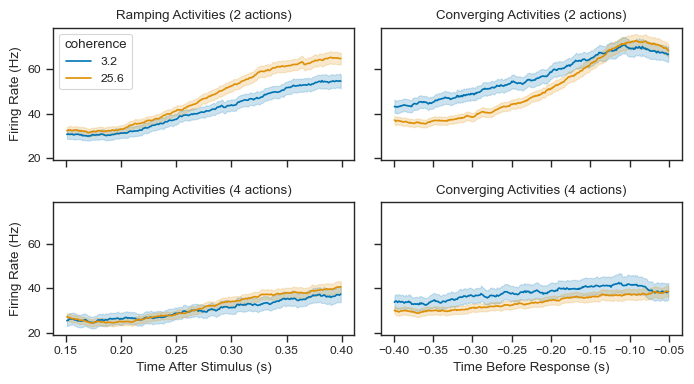

In [57]:
plot_churchland_firing()

## Compare

In [66]:
def compare_firing(simfile, empfile, coherences=[3.2, 25.6], t0=0.1, t1=0.35, t2=-0.3, t3=-0.01):
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    emp_start = emp.query("time>@t0 & time<@t1 & coherence in @coherences & accuracy==100 & nActions==2")
    emp_end = emp.query("time2>@t2 & time2<@t3 & coherence in @coherences & accuracy==100 & nActions==2")
    del(emp)
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    sim_start = sim.query("time>@t0 & time<@t1")
    sim_end = sim.query("time2>@t2 & time2<@t3")

    combined_start = pd.concat([emp_start, sim_start], ignore_index=True)
    combined_end = pd.concat([emp_end, sim_end], ignore_index=True)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((7, 3)), sharey=True, sharex=False)
    sns.lineplot(data=combined_start, x='time', y='firing rate', hue="coherence", style='type', palette=palette[:2], ax=axes[0])
    sns.lineplot(data=combined_end, x='time2', y='firing rate', hue="coherence", style='type', palette=palette[:2], ax=axes[1])
    axes[0].set(xlabel='Time After Stimulus (s)', ylabel="Firing Rate (Hz)", title=f'Ramping Activities')  # , xlim=[0.15, 0.35])
    axes[1].set(xlabel='Time Before Response (s)', title=f'Converging Activities')  # , xlim=[-0.35, -0.05])
    axes[0].legend(loc="upper left", ncols=2)
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/compare_churchland_firing2.svg")
    fig.savefig(f"plots/compare_churchland_firing2.png", dpi=600)

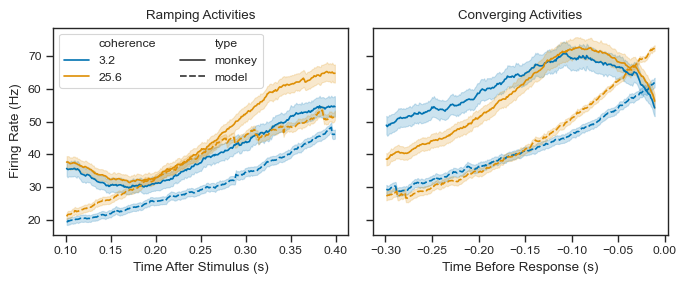

In [67]:
compare_firing("may17two_firing", "churchland2008_firing")

## Etc

In [3]:
emp = pd.read_pickle(f'data/churchland2008_behavior.pkl').query("coherence>0")
cohs = emp['coherence'].unique()
for coh in cohs:
    print(coh, len(emp.query("coherence==@coh")['trial'].unique()))

3.2 235
6.4 59
12.8 59
25.6 57
51.2 74
76.8 39
